In [1]:
import sys, os
sys.path.append('./src')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


import pandas as pd 
import numpy as np
import random 
import scanpy as sc

from model import Encoder, Decoder, OutputLayer
from loss_function import ZINB, maximum_mean_discrepancy
from train import train_epoch_mmd
from utils import plot_train, preproc_filter, vis_latent_emb
from dataset import dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the dataset
We have three batches, from day 2, 4, and 7. We hope to integrate cells from 3 batches, which is to make the latent embedding of cells from three batches merge.

In [2]:
# Data
path_pool = [
    r"./data/mtx_0.mtx", 
    r'./data/GSE65525/GSM1599497_ES_d2_LIFminus.csv', 
    r'./data/GSE65525/GSM1599498_ES_d4_LIFminus.csv', 
    r'./data/GSE65525/GSM1599499_ES_d7_LIFminus.csv'
    ]

# Loading data with scanpy
data_d2 = sc.read_csv(path_pool[1])
data_d4 = sc.read_csv(path_pool[2])
data_d7 = sc.read_csv(path_pool[3])

In [3]:
# the latent embedding of three batches should be merged
# batch 1, from day 2
counts_d2 = pd.read_csv("./data/GSE65525/GSM1599497_ES_d2_LIFminus.csv", index_col = 0, header = None).T
# batch 2, from day 4
counts_d4 = pd.read_csv("./data/GSE65525/GSM1599498_ES_d4_LIFminus.csv", index_col = 0, header = None).T
# batch 3, from day 7
counts_d7 = pd.read_csv("./data/GSE65525/GSM1599499_ES_d7_LIFminus.csv", index_col = 0, header = None).T

anno_d2 = np.array(["Day 2"] * counts_d2.shape[0])
anno_d4 = np.array(["Day 4"] * counts_d4.shape[0])
anno_d7 = np.array(["Day 7"] * counts_d7.shape[0])

anno = np.concatenate([anno_d2, anno_d4, anno_d7], axis = 0)

In [4]:
# PREVIEW
load_data_d2 = data_d2.T.copy()
load_data_d4 = data_d4.T.copy()
load_data_d7 = data_d7.T.copy()

data_batch_1, data_batch_2 = preproc_filter(load_data_d2, load_data_d4, 150)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Original shape of Data1:(303, 24175) 	 Data2:(683, 24175)
FIltered shape of Data1:(303, 5166), 	 Data2: (683, 5166)


In [5]:
batch_size = 50
seed = 222
random.seed(seed)

# construct training and testing dataset for one batch (day 4)
train_data_1 = dataset(counts = data_batch_1.X, anno = anno_d2)
train_loader_1 = DataLoader(train_data_1, batch_size = batch_size, shuffle=True)

train_data_2 = dataset(counts = data_batch_2.X, anno = anno_d4)
train_loader_2 = DataLoader(train_data_2, batch_size = batch_size, shuffle = True)


In [11]:
if data_batch_1.shape != data_batch_2.shape:
    assert ValueError
net_struc = [data_batch_1.shape[1], 512, 128, 32]

encoder = Encoder(features=net_struc).to(device)
decoder = Decoder(features=net_struc[1:][::-1]).to(device)

# Three output layer of DCA
# dropoutRates = {'mean': 0.1, 'pi': 0.1, 'theta': 0.1}
output_layer = OutputLayer(net_struc[:2][::-1]).to(device)

# Define Optimizer
lr = 1e-3

#Random seed
torch.manual_seed(seed)
param_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(param_to_optimize, lr=lr)

In [12]:
factor_zinb = 1
factor_mmd = 0.3

### Training


 EPOCH 1/200 	 train loss 0.407591709602784

 EPOCH 2/200 	 train loss 0.4103017876250516

 EPOCH 3/200 	 train loss 0.41009886587413624

 EPOCH 4/200 	 train loss 0.40885660908009747

 EPOCH 5/200 	 train loss 0.4093989004002939


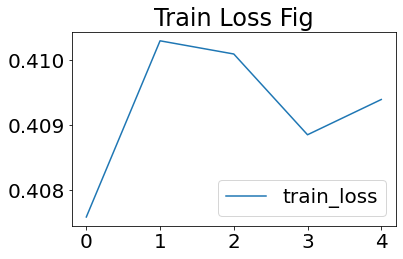


 EPOCH 6/200 	 train loss 0.4085269713952596

 EPOCH 7/200 	 train loss 0.4081660544518197

 EPOCH 8/200 	 train loss 0.40625513662206064

 EPOCH 9/200 	 train loss 0.40756867034207084

 EPOCH 10/200 	 train loss 0.4094248101262763


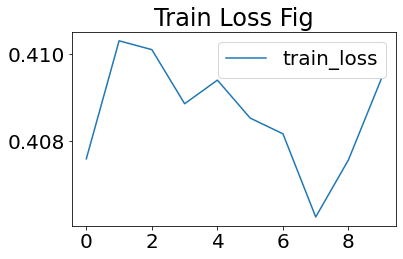


 EPOCH 11/200 	 train loss 0.4075039778605546

 EPOCH 12/200 	 train loss 0.40720760232151143

 EPOCH 13/200 	 train loss 0.4073086351451307

 EPOCH 14/200 	 train loss 0.4032065703137086

 EPOCH 15/200 	 train loss 0.40621535298061057


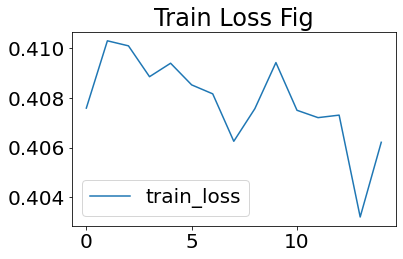


 EPOCH 16/200 	 train loss 0.40243464177197746

 EPOCH 17/200 	 train loss 0.40355858000198214

 EPOCH 18/200 	 train loss 0.4047891723834249

 EPOCH 19/200 	 train loss 0.40240638405576395

 EPOCH 20/200 	 train loss 0.4023412383428895


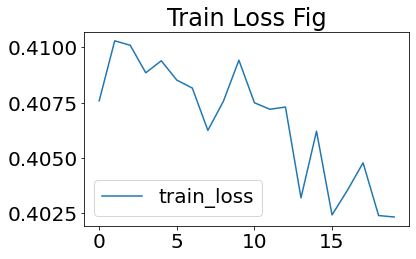


 EPOCH 21/200 	 train loss 0.4030280726971013

 EPOCH 22/200 	 train loss 0.40387531318286857

 EPOCH 23/200 	 train loss 0.3987608302151016

 EPOCH 24/200 	 train loss 0.3995568051983421

 EPOCH 25/200 	 train loss 0.4019839913144757


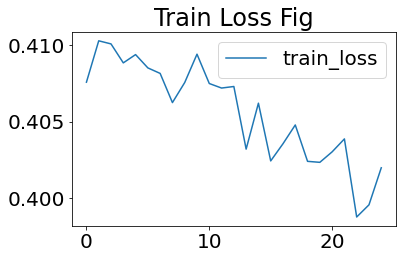


 EPOCH 26/200 	 train loss 0.40054033613047585

 EPOCH 27/200 	 train loss 0.3973641033613249

 EPOCH 28/200 	 train loss 0.39545944893714224

 EPOCH 29/200 	 train loss 0.39692504807273943

 EPOCH 30/200 	 train loss 0.3970629311237398


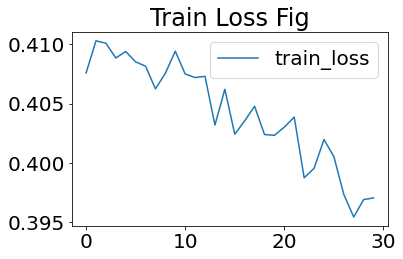


 EPOCH 31/200 	 train loss 0.39158347101494817

 EPOCH 32/200 	 train loss 0.3944701330103103

 EPOCH 33/200 	 train loss 0.3962844999709932

 EPOCH 34/200 	 train loss 0.39833908584645084

 EPOCH 35/200 	 train loss 0.39974706794562515


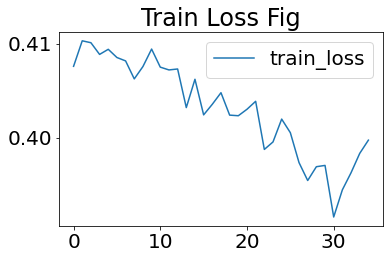


 EPOCH 36/200 	 train loss 0.39799710390197957

 EPOCH 37/200 	 train loss 0.40194655566325677

 EPOCH 38/200 	 train loss 0.40064329518736785

 EPOCH 39/200 	 train loss 0.40077626823198675

 EPOCH 40/200 	 train loss 0.4044775317604392


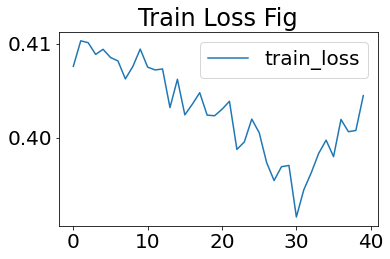


 EPOCH 41/200 	 train loss 0.39940166158644674

 EPOCH 42/200 	 train loss 0.3986964839519841

 EPOCH 43/200 	 train loss 0.40267916638465606

 EPOCH 44/200 	 train loss 0.4003910026927986

 EPOCH 45/200 	 train loss 0.402079446874436


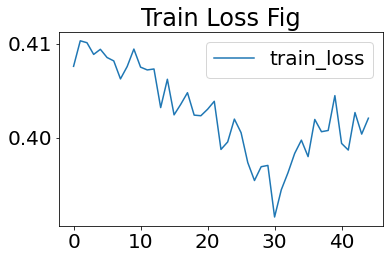


 EPOCH 46/200 	 train loss 0.3995065342868515

 EPOCH 47/200 	 train loss 0.4002971397374723

 EPOCH 48/200 	 train loss 0.3977840536891824

 EPOCH 49/200 	 train loss 0.4001704993421095

 EPOCH 50/200 	 train loss 0.39857282732973004


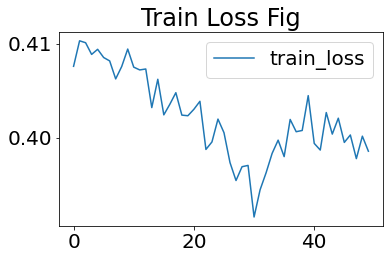


 EPOCH 51/200 	 train loss 0.4005463729203731

 EPOCH 52/200 	 train loss 0.4012985103594588

 EPOCH 53/200 	 train loss 0.4022599462628758

 EPOCH 54/200 	 train loss 0.4002181138142501

 EPOCH 55/200 	 train loss 0.4023582156341855


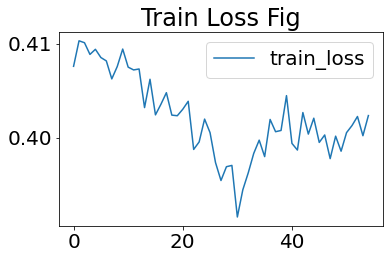


 EPOCH 56/200 	 train loss 0.4046649681066129

 EPOCH 57/200 	 train loss 0.4051612942132226

 EPOCH 58/200 	 train loss 0.4051368260147548

 EPOCH 59/200 	 train loss 0.40110190866803963

 EPOCH 60/200 	 train loss 0.4021205461458011


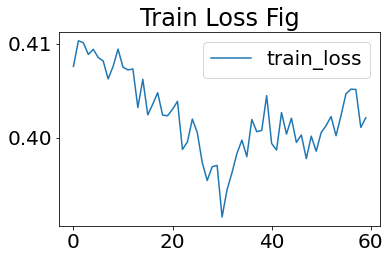


 EPOCH 61/200 	 train loss 0.4009303165347663

 EPOCH 62/200 	 train loss 0.4040059130577364

 EPOCH 63/200 	 train loss 0.4044593395573078

 EPOCH 64/200 	 train loss 0.4036386760548003

 EPOCH 65/200 	 train loss 0.40128106724704454


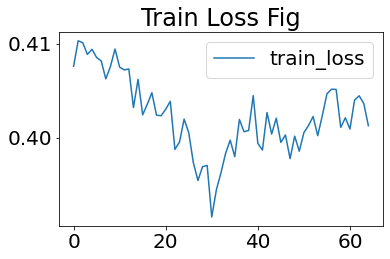


 EPOCH 66/200 	 train loss 0.402267588247167

 EPOCH 67/200 	 train loss 0.4029148592807279

 EPOCH 68/200 	 train loss 0.3984023934543723

 EPOCH 69/200 	 train loss 0.4050257969217332

 EPOCH 70/200 	 train loss 0.4002651428625529


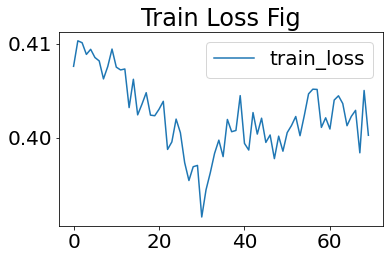


 EPOCH 71/200 	 train loss 0.39959641258315287

 EPOCH 72/200 	 train loss 0.40155228844570245

 EPOCH 73/200 	 train loss 0.39916518183037786

 EPOCH 74/200 	 train loss 0.39944881023746903

 EPOCH 75/200 	 train loss 0.3992172278980217


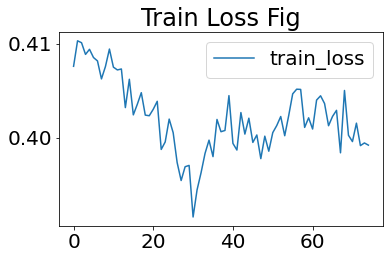


 EPOCH 76/200 	 train loss 0.39637809854136047

 EPOCH 77/200 	 train loss 0.39795862330068454

 EPOCH 78/200 	 train loss 0.3982434288503313

 EPOCH 79/200 	 train loss 0.3976259388939382

 EPOCH 80/200 	 train loss 0.39778106362119364


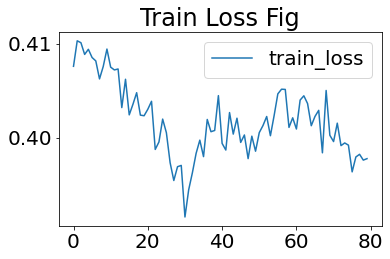


 EPOCH 81/200 	 train loss 0.3948721492251154

 EPOCH 82/200 	 train loss 0.397411850025945

 EPOCH 83/200 	 train loss 0.3931586262416525

 EPOCH 84/200 	 train loss 0.3943087574672384

 EPOCH 85/200 	 train loss 0.39733887977725996


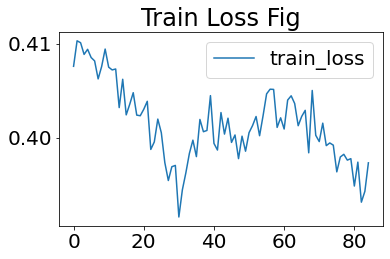


 EPOCH 86/200 	 train loss 0.3940139871225892

 EPOCH 87/200 	 train loss 0.3919344735224255

 EPOCH 88/200 	 train loss 0.397209891391666

 EPOCH 89/200 	 train loss 0.3970346356382464

 EPOCH 90/200 	 train loss 0.3929058805157249


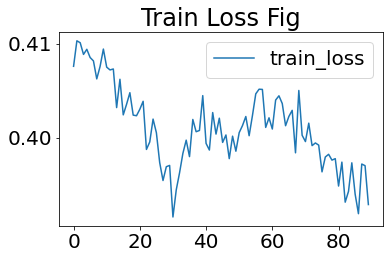


 EPOCH 91/200 	 train loss 0.3942263889627488

 EPOCH 92/200 	 train loss 0.39330872765468683

 EPOCH 93/200 	 train loss 0.39318612857226887

 EPOCH 94/200 	 train loss 0.39314911467800834

 EPOCH 95/200 	 train loss 0.3917387405244431


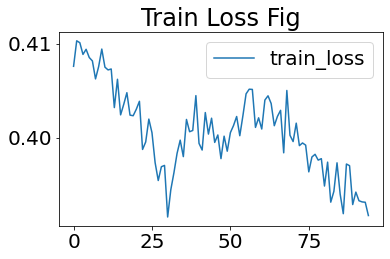


 EPOCH 96/200 	 train loss 0.39163410073459737

 EPOCH 97/200 	 train loss 0.394093913213648

 EPOCH 98/200 	 train loss 0.3917011349114648

 EPOCH 99/200 	 train loss 0.3936349094504177

 EPOCH 100/200 	 train loss 0.3932882315254841


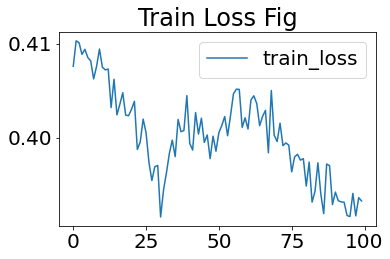


 EPOCH 101/200 	 train loss 0.39194159303167864

 EPOCH 102/200 	 train loss 0.3923003508312867

 EPOCH 103/200 	 train loss 0.39531985997366825

 EPOCH 104/200 	 train loss 0.392871888163853

 EPOCH 105/200 	 train loss 0.392406967213445


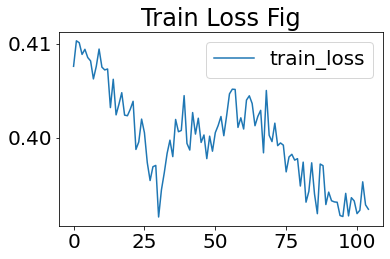


 EPOCH 106/200 	 train loss 0.3891367770657681

 EPOCH 107/200 	 train loss 0.39002663388897485

 EPOCH 108/200 	 train loss 0.39461225881041473

 EPOCH 109/200 	 train loss 0.3884231957665371

 EPOCH 110/200 	 train loss 0.3884246561786916


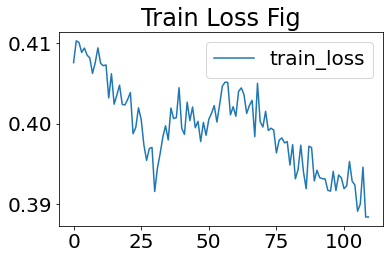


 EPOCH 111/200 	 train loss 0.39769401802088167

 EPOCH 112/200 	 train loss 0.3981544696065065

 EPOCH 113/200 	 train loss 0.39854504172951477

 EPOCH 114/200 	 train loss 0.3966262238253855

 EPOCH 115/200 	 train loss 0.39816943883109013


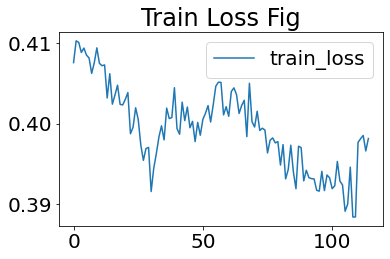


 EPOCH 116/200 	 train loss 0.3968824443250599

 EPOCH 117/200 	 train loss 0.39977320428728663

 EPOCH 118/200 	 train loss 0.40000646106480764

 EPOCH 119/200 	 train loss 0.39767178450480545

 EPOCH 120/200 	 train loss 0.3972302490335093


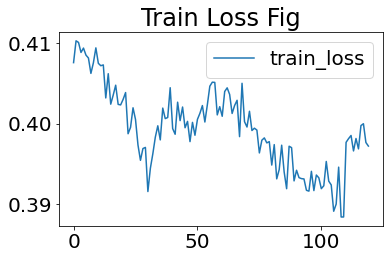


 EPOCH 121/200 	 train loss 0.39632644275627515

 EPOCH 122/200 	 train loss 0.3979349860263736

 EPOCH 123/200 	 train loss 0.3947330386725196

 EPOCH 124/200 	 train loss 0.3950853819894318

 EPOCH 125/200 	 train loss 0.397473678337072


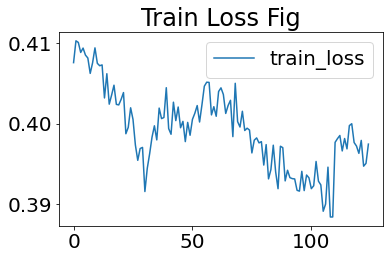


 EPOCH 126/200 	 train loss 0.3972910009201604

 EPOCH 127/200 	 train loss 0.39656530827185504

 EPOCH 128/200 	 train loss 0.3957496491989287

 EPOCH 129/200 	 train loss 0.39435402394914787

 EPOCH 130/200 	 train loss 0.3956934107412206


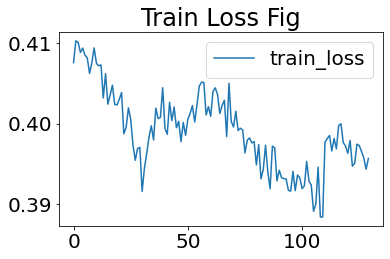


 EPOCH 131/200 	 train loss 0.39718196100921127

 EPOCH 132/200 	 train loss 0.39445894071371246

 EPOCH 133/200 	 train loss 0.3979819143565968

 EPOCH 134/200 	 train loss 0.3965773063130898

 EPOCH 135/200 	 train loss 0.39497223152185823


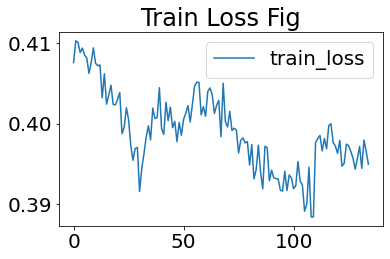


 EPOCH 136/200 	 train loss 0.39716477598687605

 EPOCH 137/200 	 train loss 0.396382209097985

 EPOCH 138/200 	 train loss 0.3943414908431151

 EPOCH 139/200 	 train loss 0.3951886557903227

 EPOCH 140/200 	 train loss 0.392910368765148


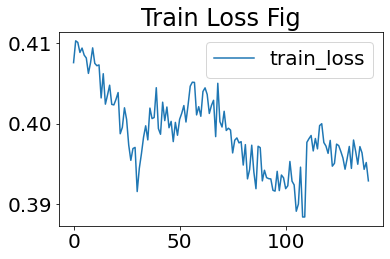


 EPOCH 141/200 	 train loss 0.3896674354477684

 EPOCH 142/200 	 train loss 0.3934950309224648

 EPOCH 143/200 	 train loss 0.39312167529619174

 EPOCH 144/200 	 train loss 0.39240312733665944

 EPOCH 145/200 	 train loss 0.394733466724358


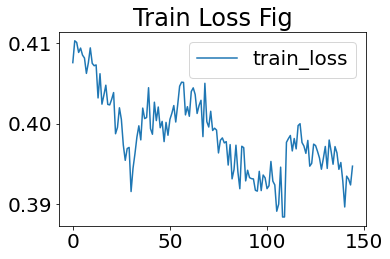


 EPOCH 146/200 	 train loss 0.3911388573473436

 EPOCH 147/200 	 train loss 0.3918777125896794

 EPOCH 148/200 	 train loss 0.3887338355036065

 EPOCH 149/200 	 train loss 0.39059854891433965

 EPOCH 150/200 	 train loss 0.39005064256120436


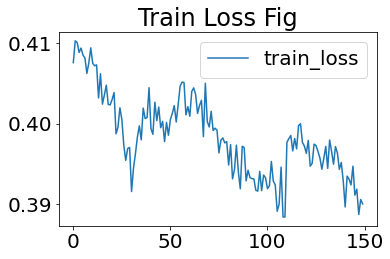


 EPOCH 151/200 	 train loss 0.39030997273158713

 EPOCH 152/200 	 train loss 0.38831831677125234

 EPOCH 153/200 	 train loss 0.38933403971958475

 EPOCH 154/200 	 train loss 0.3904435060205239

 EPOCH 155/200 	 train loss 0.38977168495505554


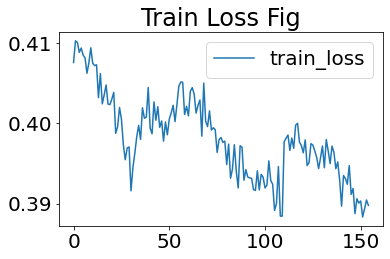


 EPOCH 156/200 	 train loss 0.38787325616716944

 EPOCH 157/200 	 train loss 0.38726608981393745

 EPOCH 158/200 	 train loss 0.3902041557991859

 EPOCH 159/200 	 train loss 0.38703241127945803

 EPOCH 160/200 	 train loss 0.38778154606079507


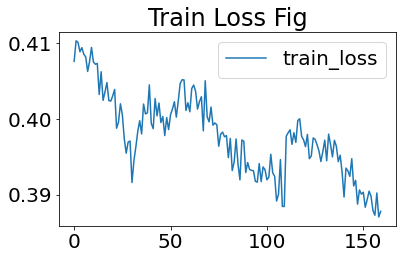


 EPOCH 161/200 	 train loss 0.3861181366168233

 EPOCH 162/200 	 train loss 0.3828890016763517

 EPOCH 163/200 	 train loss 0.38253212919329654

 EPOCH 164/200 	 train loss 0.3889748727527782

 EPOCH 165/200 	 train loss 0.389698324423812


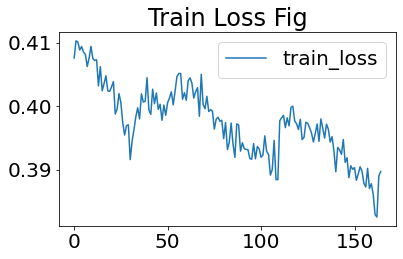


 EPOCH 166/200 	 train loss 0.39023816074081774

 EPOCH 167/200 	 train loss 0.3944538103865318

 EPOCH 168/200 	 train loss 0.39335242041660223

 EPOCH 169/200 	 train loss 0.39046113797933746

 EPOCH 170/200 	 train loss 0.3883252222545863


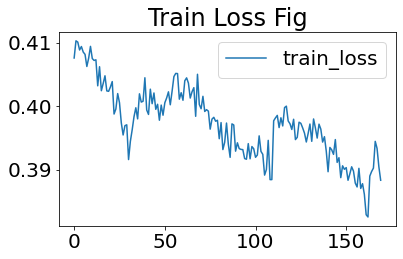


 EPOCH 171/200 	 train loss 0.39190178421070865

 EPOCH 172/200 	 train loss 0.3912946304472366

 EPOCH 173/200 	 train loss 0.395917288147577

 EPOCH 174/200 	 train loss 0.3930716121157404

 EPOCH 175/200 	 train loss 0.3884974186963374


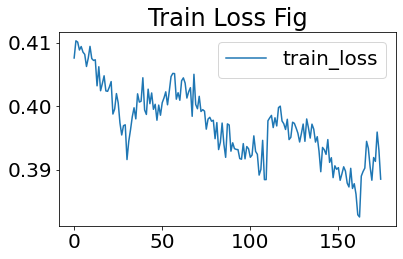


 EPOCH 176/200 	 train loss 0.391516103209442

 EPOCH 177/200 	 train loss 0.3911334815198439

 EPOCH 178/200 	 train loss 0.39242884192136257

 EPOCH 179/200 	 train loss 0.3918431285190897

 EPOCH 180/200 	 train loss 0.3931384070871687


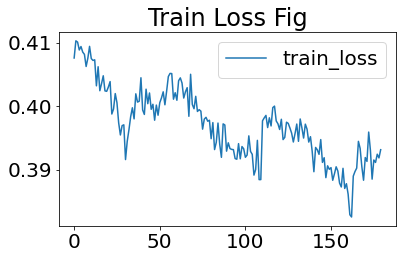


 EPOCH 181/200 	 train loss 0.3921150799238249

 EPOCH 182/200 	 train loss 0.39693328807062833

 EPOCH 183/200 	 train loss 0.3964020883289501

 EPOCH 184/200 	 train loss 0.39495802397775176

 EPOCH 185/200 	 train loss 0.3939078617410691


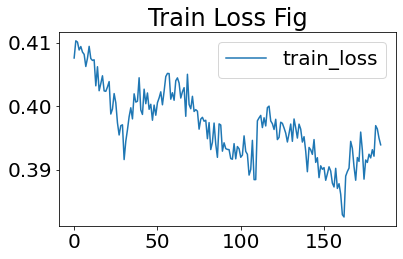


 EPOCH 186/200 	 train loss 0.39293386755209947

 EPOCH 187/200 	 train loss 0.3898687205298899

 EPOCH 188/200 	 train loss 0.3904984729124768

 EPOCH 189/200 	 train loss 0.39056766623317607

 EPOCH 190/200 	 train loss 0.38969677588333784


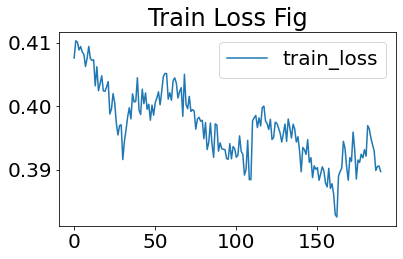


 EPOCH 191/200 	 train loss 0.3928450027314743

 EPOCH 192/200 	 train loss 0.3911226983904445

 EPOCH 193/200 	 train loss 0.39234805972662695

 EPOCH 194/200 	 train loss 0.3925990743605611

 EPOCH 195/200 	 train loss 0.390008536109043


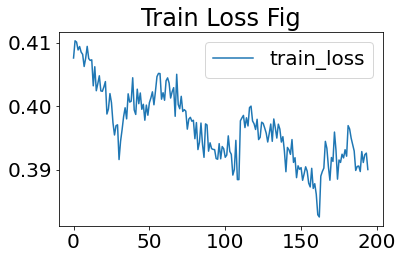


 EPOCH 196/200 	 train loss 0.39111170123512595

 EPOCH 197/200 	 train loss 0.39037207801743307

 EPOCH 198/200 	 train loss 0.3911492187197846

 EPOCH 199/200 	 train loss 0.392403769414417

 EPOCH 200/200 	 train loss 0.3956308648137763


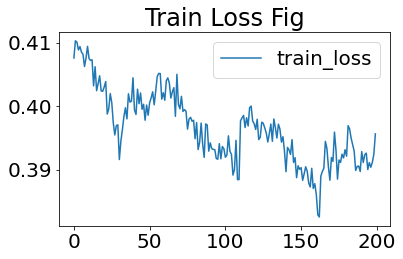

In [14]:
num_epochs = 200
all_loss = {'train_loss':[],'test_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch_mmd(encoder,decoder,output_layer,train_loader_1, train_loader_2,optim,factor_zinb,factor_mmd)
    print('\n EPOCH {}/{} \t train loss {}'.format(epoch + 1, num_epochs,train_loss))
    all_loss['train_loss'].append(train_loss)
    all_loss['test_loss'].append(0)
    if epoch and (epoch + 1) % 5 == 0:
        plot_train(all_loss)

### Visualize the latent embedding

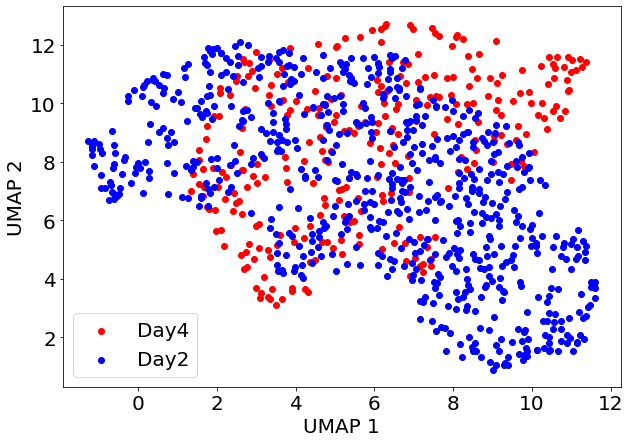

In [17]:
test_loader_2 = DataLoader(train_data_2, batch_size = train_data_2.counts.shape[0], shuffle = False)
test_loader_1 = DataLoader(train_data_1, batch_size = train_data_1.counts.shape[0], shuffle = False)
vis_latent_emb(test_loader_1, test_loader_2, encoder, device)